In [2]:
# procedure for calculating hydraulic confinement along a pressure tunnel 
# procedure will be documented as a design report
#  calculation done at stationed points at a selected interval along tunnel alignment
#  calculation determines the minimum dstance from the stationed point to the terrain surface 

In [3]:
# ToDo
#   put common functions (e.g. setup, data format conversions) into a separate module/API
#     http://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html
#     https://stackoverflow.com/questions/16966280/reusing-code-from-different-ipython-notebooks [%run magic]

In [4]:
# import required python libraires
import numpy as np
#from numpy import *
import pandas as pd
import geopandas as gpd
import shapely as sp
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# python setup for qgis processing
import sys, os
from qgis.core import QgsApplication
from PyQt4.QtGui import QApplication
app = QApplication([], True)  #True -> 
QgsApplication.setPrefixPath("/usr", True)
QgsApplication.initQgis()
sys.path.append('/usr/share/qgis/python/plugins')  #export PYTHONPATH not needed in start script
from processing.core.Processing import Processing
Processing.initialize() 
#from processing.tools import *  #not needed currently
import processing

In [6]:
# import DSS modules
#import geospatial as geo

In [7]:
# set wd for this procedure 
os.chdir("/home/kaelin_joseph/DSS.HydraulicConfinement/")

In [8]:
# system checking
#import sys
#print(geo.__name__)
#print(dir(geo))
#print(dir(geo.__builtins__))
#print(dir(geo.__package__))
#print(sys.getrefcount(sys))
#sys.modules
#del sys.modules['geospatial']
#print(sys.getrefcount(sys))
#print(os.environ['PYTHONPATH'])
#print(sys.path)

In [9]:
# define required input files
DTM = "data/swissALTI3D_.tif"  #DEM with surface topography
Alignment = "data/TestAlignment.p0.csv"  #tunnel alignment

In [10]:
# temporary data
Alignment_SHP ='tmp/TestAlignment.shp'  #alignment shp from Alignment
Alignment_grass = 'tmp/TestAlignmentGrass.csv'  #alignment csv fixed for grass
Alignment_line = "tmp/TestAlignmentLine.shp"  #intermediate data
Alignment_points = "tmp/TestAlignmentPoints.shp"  #alignment containing station points
Alignment_DTM = "tmp/TestAlignmentDTM.csv"  #alignment including terrain elevations at station points
Buffer_SHP = "tmp/TestBuffer.shp"  #buffer shp containing ring grid points at a particular station point
Test_buffer_csv = "tmp/TestBuffer.csv"  #buffer written to csv

In [11]:
# define output files


In [12]:
# create alignment_df (dataframe) from alignment csv                         #ToDo JK: make into csv -> df function
#   required alignment input data: x_align, y_align, z_align at alignment definition points
#   check csv data before creating df (no trailing blank lines, no duplicate lines)
alignment_df = pd.read_csv(Alignment)
# delete row if only NA are present in row
alignment_df = alignment_df.dropna(how = "all")
# round alignment_df to three decimals
alignment_df = alignment_df.round(decimals=3)

In [13]:
alignment_df

,Point,Type,Station,Northing,Easting,Elevation
0,0,NaN,204+874.1,1269294.122,2612071.548,270.962
1,221,PT,205+389.861,1269029.594,2612426.331,253.058
2,EC10:3,EC,209+528.128,1265960.779,2614558.633,268.579


In [29]:
# create segmented polyline representing alignment from points in alignment_df
#   grass input for function v.in.line 1) nust have x first and y second; 2) no header 
#   required output data: x_align, y_align at each station point            #ToDo JK: make into stationing function
alignment_df_grass = alignment_df.loc[:,["Easting", "Northing"]]  #x first and y second
alignment_df_grass.to_csv(Alignment_grass, header=False, index=False)  #no header

# points to line 
#geo.v_in_lines(Alignment_grass, Alignment_line)  #call function from imported geo module
processing.runalg("grass7:v.in.lines",Alignment_grass,",",False,
                      "2605158.67928,2621471.50192,1265877.44552,1269377.45567",0,Alignment_line)
    
# line to station points
#geo.v_to_points(Alignment_line, Alignment_points)  #call function from imported geo module
processing.runalg("grass7:v.to.points",Alignment_line,"100",1,True,
                  "2603510,2624270,1260650,1274890",-1,0.0001,0,Alignment_points)

{'output': 'tmp/TestAlignmentPoints.shp'}

In [15]:
# create alignment_SHP from alignment_df for checking                       #ToDo JK: make into df -> shp function
alignment_spatial_points = [sp.geometry.Point(row['Easting'], row['Northing'])
                            for key, row in alignment_df.iterrows()]
alignment_crs = {'init': 'epsg:2056'}  #define crs
alignment_spatial = gpd.GeoDataFrame(alignment_df, geometry=alignment_spatial_points, crs = alignment_crs)
alignment_spatial.to_file(Alignment_SHP, driver='ESRI Shapefile') 

#print(alignment_spatial)

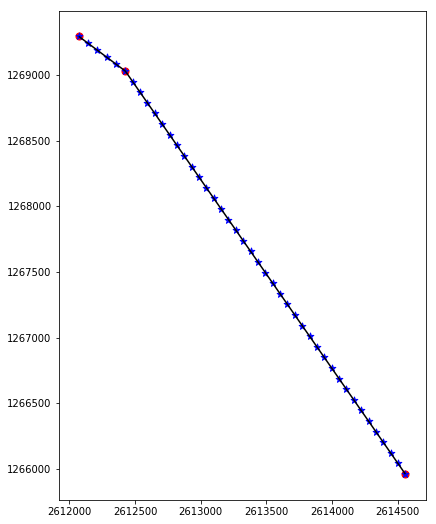

In [16]:
# plot alignment for checking
#   reference: http://nbviewer.jupyter.org/gist/perrygeo/c426355e40037c452434
pylab.rcParams['figure.figsize'] = 13.5, 9

# get data to plot
line = gpd.GeoDataFrame.from_file(Alignment_line)
point1 = gpd.GeoDataFrame.from_file(Alignment_SHP)
point2 = gpd.GeoDataFrame.from_file(Alignment_points)

# plot
base = line.plot(color='black')
#point1.plot(ax=base, marker='o', color='red', markersize=10, markeredgewidth=0.0)
#point2.plot(ax=base, marker='*', color='blue', markersize=10, markeredgewidth=0.0)
 # AttributeError: 'GeoDataFrame' object has no attribute 'plt'  ??
point1.plot(ax=base, marker='o', color='red', markersize=50)
point2.plot(ax=base, marker='*', color='blue', markersize=50)

In [30]:
# create alignment_points_df from Alignment_points shp                       #ToDo JK: make into shp -> df function
#   required output data: id_align, x_align, y_align at each station point
alignment_points_df = gpd.read_file(Alignment_points)
#type(alignment_points_df)
alignment_points_df.head()

# create columns for Easting and Northing, then delete columns cat_ and geometry                          #ToDo KLK




,cat_,geometry
0,1,POINT (2612071.548 1269294.122)
1,1,POINT (2612142.5046 1269241.2164)
2,1,POINT (2612213.4612 1269188.3108)
3,1,POINT (2612284.4178 1269135.4052)
4,1,POINT (2612355.3744 1269082.4996)


In [18]:
# interpolate alignment elevations at all station points and write to alignment_points_df                 #ToDo KLK
#   join alignment_points_df with alignment_df
#   required output data: z_align at each station point                #ToDo JK: make into z interpolation function




In [19]:
# use grass7:r.what.points to get DTM value for z for points along alignment and write to .csv file
processing.runalg(                                                         #ToDo JK: make into what.points function
                  "grass7:r.what.points",DTM,Alignment_points,
                  "NA",",",500,True,False,False,False,False,
                  "2603510.0,2624270.0,1260650.0,1274890.0",-1,0.0001,Alignment_DTM
                 )
#out = open(Alignment_DTM, 'r')
#print(out.read())  #check

This can cause unexpected results.


{'output': 'tmp/TestAlignmentDTM.csv'}

In [20]:
# read Alignment_DTM csv and write to alignment_points_df             #ToDo JK: reuse function csv -> df from above
#   required output data: z_dtm at each station point





In [21]:
# prepare circular grid as buffer around a station point and determine minimal distance to terrain surface 
#   this calculation is defined as a function, to be applied at each station point
#   inputs are easting, northing, overburden at stationed point (and a coeff for buffer_radius = coeff*cover) 

# input data  #temporarily static
point = np.array([2612060, 1268065])  #station point [from alignment_points_df]
h = 110.0  #overburden depth above station point [calculate from alignment_points_df]

def make_buffer(point, overburden):
    c = 0.5  #buffer radius = c*h
    res = 20.0  #nominal grid resolution 
    intvls_r = int(h*c / res)  #number of intervals along the buffer radius, close enough
    res_r = h*c / intvls_r  #effective resolution along the radius
    buffer = np.array(point)  #initialize buffer, first item is exactly at station point
    print("buffer: "+str(buffer))

    # calculate local coordinates for grid along a ring
    for i in range(intvls_r):
        r = c*h - i*res_r
        perim = 2 * r * pi 
        intvls_c = int(perim/res)  #number of intervals along a ring, close enough
        item = np.array([0.0, 0.0])  #initialize
        for j in range(intvls_c):
            item[0] = (sin((2*pi) / intvls_c *(j+1)) *r) + point[0]
            item[1] = (cos((2*pi) / intvls_c *(j+1)) *r) + point[1]
            buffer = np.vstack((buffer, item))  #vstack works with arrays of diff nr of items, append does not        

        print("r: "+str(r))
        print("intvls_r: "+str(intvls_r))
        print("intvls_c: "+str(intvls_c))
        return buffer
        
buffer = make_buffer(point=point, overburden=h)        

buffer: [2612060 1268065]
r: 55.0
intvls_r: 2
intvls_c: 17


In [32]:
# use make_buffer to get buffer grid points at all station points along alignment                         #ToDo KLK
#   write buffer points to buffer_df and to alignment_points_df
#   required output data: id_align, id_buffer, x_buffer, y_buffer, z_dtm at each buffer point  

# temporary code for handling one buffer
# create Buffer_SHP for grass from buffer
crs = {'init': 'epsg:2056'}  #define crs

buffer_df = pd.DataFrame.from_records(data=buffer, columns=['Easting', 'Northing'], index=None)
#buffer_df





In [23]:
# create shp file with all buffer points                                         #ToDo JK: reuse df -> shp function
buffer_points = [sp.geometry.Point(row['Easting'], row['Northing'])
                 for key, row in buffer_df.iterrows()]
#len(buffer_points)  #check

# write buffer to Buffer_SHP as shape file
buffer_spatial = gpd.GeoDataFrame(buffer_df, geometry=buffer_points, crs = crs)
buffer_spatial.to_file(Buffer_SHP, driver='ESRI Shapefile') 
#print(buffer_spatial)  #check
print(Buffer_SHP)

tmp/TestBuffer.shp


In [24]:
# use grass7:r.what.points to read Buffer_SHP to get z_dtm at each buffer point for all station points

# temporary code for handling one buffer
# use grass7:r.what.points to read Buffer_SHP to get z_dtm at each point
test_buffer_csv = "tmp/test_buffer.csv"
# buffer_SHP = {'init': 'epsg:2056'}  #define crs
processing.runalg("grass7:r.what.points",DTM,Buffer_SHP,            #ToDo JK: reuse what.points function from above
                  "NA",",",500,True,False,False,False,False,
                  "2603510.0,2624270.0,1260650.0,1274890.0",-1,0.0001,test_buffer_csv
                 )

out = open(test_buffer_csv, 'r')
print(out.read())  #check

This can cause unexpected results.
easting,northing,site_name,tmp1516291224315
2612060,1268065,,256.412
2612079.86829164,1268116.28597262,,256.6162
2612097.0532604,1268105.64549045,,256.5174
2612109.23398102,1268089.51560957,,256.5334
2612114.7653797,1268070.07475977,,256.4881
2612112.90041037,1268049.94853555,,256.3598
2612103.8909475,1268031.855095,,256.6074
2612088.95376896,1268018.23805753,,256.6067
2612070.10622348,1268010.93647952,,256.6189
2612049.89377652,1268010.93647952,,256.6505
2612031.04623104,1268018.23805753,,256.4118
2612016.1090525,1268031.855095,,256.4726
2612007.09958963,1268049.94853555,,256.4409
2612005.2346203,1268070.07475977,,256.3811
2612010.76601898,1268089.51560957,,256.5326
2612022.9467396,1268105.64549045,,256.7122
2612040.13170836,1268116.28597262,,257.1815
2612060,1268120,,256.6701



In [25]:
# read buffer points from Test_buffer_csv into alignment_points_df
#   required output data: id_align, id_buffer, x_buffer, y_buffer, z_dtm at each buffer point  
                                                                      #ToDo JK: reuse function csv -> df from above





In [26]:
# calculate minimum distance to terrain in each buffer ring
#   required output data: dist for each buffer point, min_dist for buffer ring





In [27]:
# calculate hydraulic confinement safety factor at each station point
#   required input data: reference maximum water pressure elevation (static or dynamic ??) 





In [28]:
# plot results for hydraulic confinement safety factor as horizontal bar beneath longitudinal profile 



